In [1]:
# 11_knn_feature_space.ipynb
# Metric comparison for k-Nearest Neighbours in audio feature space (MPD-overlap universe)

from pathlib import Path
import sys
from collections import defaultdict
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Make src/ importable
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_RAW = PROJECT_ROOT / "data" / "raw"


PROJECT_ROOT: C:\Users\Kiera\Music_Recommender


In [2]:
# Combined audio feature dataset (built earlier)
combined_path = DATA_PROCESSED / "combined_features.csv"
feat_df_raw = pd.read_csv(combined_path)

print("combined_features.csv shape:", feat_df_raw.shape)
feat_df_raw.head()


combined_features.csv shape: (4589288, 17)


,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,explicit,time_signature,popularity
0,0000QuApNltQzqS5ROXcQ7,0.629,0.199,4,-15.258,1,0.0610,0.9250,0.000000,0.1100,0.587,66.469,141813.0,2012.0,NaN,4.0,NaN
1,0000j9zugybaOxAeENtFRU,0.680,0.378,5,-7.379,1,0.0685,0.8850,0.000013,0.1200,0.963,116.877,112107.0,NaN,NaN,4.0,NaN
2,0000korRHja9p9XaR5UA5m,0.708,0.714,6,-7.579,1,0.0362,0.3970,0.000047,0.3540,0.756,120.538,235666.0,1995.0,NaN,4.0,NaN
3,0000uJA4xCdxThagdLkkLR,0.458,0.591,5,-5.621,1,0.0326,0.5680,0.000015,0.2860,0.654,184.913,161187.0,NaN,NaN,3.0,NaN
4,00018DRtkxXS7SmAG4ciN6,0.456,0.324,8,-11.521,1,0.0342,0.0242,0.596000,0.0868,0.522,184.970,238827.0,NaN,NaN,3.0,NaN


In [3]:
# Track metadata (built from MPD)
meta_path = DATA_PROCESSED / "track_metadata.csv"
meta_df = pd.read_csv(meta_path)
meta_df["track_id"] = meta_df["track_id"].astype(str)

print("track_metadata.csv shape:", meta_df.shape)
meta_df.head()


track_metadata.csv shape: (679889, 7)


,track_id,track_name,artist_name,album_name,artist_uri,album_uri,duration_ms
0,0000uJA4xCdxThagdLkkLR,Heart As Cold As Stone,Cherryholmes,Cherryholmes,spotify:artist:5kEVfWQGTw0rIDO2Jqq1ww,spotify:album:3SPMBGMEvPw21lmT5b1ApW,161186
1,00039MgrmLoIzSpuYKurn9,Thas What I Do,Zach Farlow,The Great Escape 2,spotify:artist:2jTojc4rAsOMx6200a8Ah1,spotify:album:0UHfgx3ITlxePDXLaN5Y6x,222727
2,0005w1bMJ7QAMl6DY98oxa,"Sonata in G Major, BuxWV 271: Allegro -",Dietrich Buxtehude,"Chamber Music: London Baroque - Rosenmuller, J...",spotify:artist:2YfFYZnshSzgfLsKZMM4VL,spotify:album:6oRWciCAwKegipcCc5FlWe,111573
3,0007AYhg2UQbEm88mxu7js,Mandarin Oranges Part 2,Little Simz,E.D.G.E,spotify:artist:6eXZu6O7nAUA5z6vLV8NKI,spotify:album:32RJzqlapfiU0fr2l4SSW9,198000
4,000CTwOSsvRs0bgXlwB64e,Shady World,Celly Cel,The Lost Tapes,spotify:artist:6k7TX5dxiKZiwMWTn8ZKbl,spotify:album:6LOmO9x8uPwlc3gSXZqqi8,155238


In [4]:
# Playlist interactions (from MPD)
interactions_path = DATA_PROCESSED / "interactions.parquet"
interactions = pd.read_parquet(interactions_path)
interactions["track_id"] = interactions["track_id"].astype(str)

print("interactions.parquet shape:", interactions.shape)
interactions.head()


interactions.parquet shape: (6685101, 4)


,pid,track_id,pos,duration_ms
0,0,0UaMYEvWZi0ZqiDOoHU3YI,0,226863
1,0,6I9VzXrHxO9rA9A5euc8Ak,1,198800
2,0,0WqIKmW4BTrj3eJFmnCKMv,2,235933
3,0,1AWQoqb9bSvzTjaLralEkT,3,267266
4,0,1lzr43nnXAijIGYnCT8M8H,4,227600


In [5]:
# Intersect track_ids between features and metadata
feat_df_raw["track_id"] = feat_df_raw["track_id"].astype(str)

feature_ids = set(feat_df_raw["track_id"])
meta_ids = set(meta_df["track_id"])

overlap_ids = feature_ids & meta_ids
print("Feature IDs:", len(feature_ids))
print("Meta IDs:   ", len(meta_ids))
print("Overlap IDs:", len(overlap_ids))

# Filter to overlap universe
feat_df = feat_df_raw[feat_df_raw["track_id"].isin(overlap_ids)].copy()
meta_df_overlap = meta_df[meta_df["track_id"].isin(overlap_ids)].copy()

print("feat_df shape (overlap):", feat_df.shape)
print("meta_df_overlap shape:", meta_df_overlap.shape)

# Filter interactions to tracks in the overlap universe
interactions_overlap = interactions[interactions["track_id"].isin(overlap_ids)].copy()
print("interactions_overlap shape:", interactions_overlap.shape)


Feature IDs: 4589288
Meta IDs:    679889
Overlap IDs: 514672
feat_df shape (overlap): (514672, 17)
meta_df_overlap shape: (514672, 7)
interactions_overlap shape: (6175813, 4)


In [6]:
# Explicitly choose the audio features we care about
# (we exclude popularity, year, explicit here)
candidate_features = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

# Keep only those that actually exist in the DataFrame
feature_cols = [c for c in candidate_features if c in feat_df.columns]
print("Using feature columns:", feature_cols)

# Ensure numeric types and handle missing values with median imputation
feat_sub = feat_df[["track_id"] + feature_cols].copy()

for col in feature_cols:
    feat_sub[col] = pd.to_numeric(feat_sub[col], errors="coerce")

# Impute missing values with median per column
medians = feat_sub[feature_cols].median()
feat_sub[feature_cols] = feat_sub[feature_cols].fillna(medians)

# Build matrix and track id array
track_ids = feat_sub["track_id"].values
X_raw = feat_sub[feature_cols].values.astype(float)

print("X_raw shape:", X_raw.shape)
print("Example row:", X_raw[0])


Using feature columns: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
X_raw shape: (514672, 13)
Example row: [ 4.58000e-01  5.91000e-01  5.00000e+00 -5.62100e+00  1.00000e+00
  3.26000e-02  5.68000e-01  1.54000e-05  2.86000e-01  6.54000e-01
  1.84913e+02  1.61187e+05  3.00000e+00]


In [7]:
# Mapping from track_id to row index in X_raw
track_id_to_idx = {tid: i for i, tid in enumerate(track_ids)}

# Sanity check
print("Number of unique track_ids:", len(track_ids))
print("Mapping example:", list(track_id_to_idx.items())[:3])


Number of unique track_ids: 514672
Mapping example: [('0000uJA4xCdxThagdLkkLR', 0), ('00039MgrmLoIzSpuYKurn9', 1), ('0005w1bMJ7QAMl6DY98oxa', 2)]


In [8]:
# Z-score each feature across tracks
feat_means = X_raw.mean(axis=0)
feat_stds = X_raw.std(axis=0)
feat_stds_safe = np.where(feat_stds == 0, 1.0, feat_stds)

X_z = (X_raw - feat_means) / feat_stds_safe

print("X_z shape:", X_z.shape)
print("Mean (approx):", X_z.mean(axis=0)[:5])
print("Std (approx):", X_z.std(axis=0)[:5])


X_z shape: (514672, 13)
Mean (approx): [-3.09027664e-16  1.45650548e-16  6.60466559e-17 -8.75836089e-17
  1.22374071e-16]
Std (approx): [1. 1. 1. 1. 1.]


In [9]:
# PCA on Z-scored features
pca_5 = PCA(n_components=5, random_state=42)
X_pca5 = pca_5.fit_transform(X_z)

pca_8 = PCA(n_components=8, random_state=42)
X_pca8 = pca_8.fit_transform(X_z)

print("X_pca5 shape:", X_pca5.shape)
print("X_pca8 shape:", X_pca8.shape)


X_pca5 shape: (514672, 5)
X_pca8 shape: (514672, 8)


In [10]:
N_NEIGHBORS = 51  # 1 self + up to 50 neighbours if needed

models = {}

def fit_knn_model(name, X, metric):
    nn = NearestNeighbors(
        n_neighbors=N_NEIGHBORS,
        metric=metric,
        algorithm="brute",
        n_jobs=-1,
    )
    nn.fit(X)
    models[name] = {
        "nn": nn,
        "X": X,
        "metric": metric,
    }
    print(f"Fitted model '{name}' on X.shape={X.shape}, metric='{metric}'")


fit_knn_model("cosine_z", X_z, "cosine")
fit_knn_model("euclidean_z", X_z, "euclidean")
fit_knn_model("manhattan_z", X_z, "manhattan")
fit_knn_model("pca5_euclidean", X_pca5, "euclidean")
fit_knn_model("pca8_euclidean", X_pca8, "euclidean")


Fitted model 'cosine_z' on X.shape=(514672, 13), metric='cosine'
Fitted model 'euclidean_z' on X.shape=(514672, 13), metric='euclidean'
Fitted model 'manhattan_z' on X.shape=(514672, 13), metric='manhattan'
Fitted model 'pca5_euclidean' on X.shape=(514672, 5), metric='euclidean'
Fitted model 'pca8_euclidean' on X.shape=(514672, 8), metric='euclidean'


In [11]:
meta_df_overlap["track_id"] = meta_df_overlap["track_id"].astype(str)

def find_track_ids_by_name(query: str, max_results: int = 10) -> pd.DataFrame:
    """
    Simple case-insensitive search over track_name to help pick seeds.
    """
    mask = meta_df_overlap["track_name"].str.contains(query, case=False, na=False)
    results = meta_df_overlap[mask].head(max_results)
    return results[["track_id", "track_name", "artist_name", "album_name"]]


# Quick test
find_track_ids_by_name("ocean eyes", max_results=10)


,track_id,track_name,artist_name,album_name
115256,1JbuC7uZm0P1PyX7N7gDEM,Ocean Eyes - GOLDHOUSE Remix,Billie Eilish,Ocean Eyes
246347,2olNHiPoHP5SG6w2b84QEd,Ocean Eyes,The Copper Children,What We Are
296150,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me
314330,3bM4b4P6QFDnjdXXI2zufO,Ocean Eyes - Cautious Clay Remix,Billie Eilish,Ocean Eyes
359309,475HVfoKML70xddRf06X4h,Ocean Eyes,Kool&Klean,Volume I
365109,4BCGi8gpTqqN8RzyykvLoF,Ocean Eyes,Dylan Wright,Ocean Eyes - Single
377250,4JuZQeSRYJfLCqBgBIxxrR,Ocean Eyes - Blackbear Remix,Billie Eilish,Ocean Eyes
556358,6NOq79ynBpBi6BSJMdgReN,Ocean Eyes - Astronomyy Remix,Billie Eilish,Ocean Eyes
596823,6q2NdteQRnT3FdRMiZm1Pn,Blue Ocean Eyes (feat. Sevar),Vugarixx,Blue Ocean Eyes (feat. Sevar)


In [12]:
def knn_recommend(
    model_name: str,
    seed_track_id: str,
    top_k: int = 10,
) -> pd.DataFrame:
    """
    Use a specified kNN model to find the top_k nearest neighbours of a seed track.

    Args:
        model_name: one of models.keys()
        seed_track_id: ID of the seed track
        top_k: number of neighbours to return

    Returns:
        DataFrame with track_id, distance, similarity (if metric supports it),
        and metadata (track_name, artist_name, album_name, etc.).
    """
    if model_name not in models:
        raise ValueError(f"Unknown model '{model_name}'. Available: {list(models.keys())}")
    if seed_track_id not in track_id_to_idx:
        raise ValueError(f"track_id {seed_track_id} not in track_id_to_idx.")

    nn = models[model_name]["nn"]
    X = models[model_name]["X"]

    idx = track_id_to_idx[seed_track_id]
    seed_vec = X[idx].reshape(1, -1)

    distances, indices = nn.kneighbors(seed_vec, n_neighbors=top_k + 1)
    distances = distances[0]
    indices = indices[0]

    # Exclude self if present
    mask = indices != idx
    distances = distances[mask]
    indices = indices[mask]

    distances = distances[:top_k]
    indices = indices[:top_k]

    neighbor_ids = [track_ids[i] for i in indices]

    # Convert distance to similarity if using cosine; otherwise just leave None
    metric = models[model_name]["metric"]
    if metric == "cosine":
        similarities = 1.0 - distances
    else:
        similarities = [np.nan] * len(distances)

    recs = pd.DataFrame({
        "track_id": neighbor_ids,
        "distance": distances,
        "similarity": similarities,
    })

    recs = recs.merge(meta_df_overlap, on="track_id", how="left")

    return recs


In [13]:
def compare_metrics_for_track_name(
    query: str,
    candidate_index: int = 0,
    top_k: int = 10,
    model_names=None,
):
    """
    1. Search for tracks by name.
    2. Select one as seed.
    3. For each model in model_names, show the top_k neighbours.

    Prints seed and returns dict of DataFrames keyed by model_name.
    """
    if model_names is None:
        model_names = list(models.keys())

    matches = find_track_ids_by_name(query, max_results=20)
    if matches.empty:
        raise ValueError(f"No tracks found matching '{query}'")

    if not (0 <= candidate_index < len(matches)):
        raise IndexError(f"candidate_index {candidate_index} out of range for {len(matches)} matches.")

    print("Search results:")
    display(matches.reset_index(drop=True))

    chosen = matches.iloc[candidate_index]
    seed_id = chosen["track_id"]

    print("\nChosen seed track:")
    display(chosen[["track_name", "artist_name", "album_name", "track_id"]])

    results = {}
    for mname in model_names:
        print(f"\n=== Recommendations for model: {mname} ===")
        recs = knn_recommend(mname, seed_id, top_k=top_k)
        display(recs[["track_name", "artist_name", "album_name", "distance", "similarity"]])
        results[mname] = recs

    return results


In [14]:
results_ocean_eyes = compare_metrics_for_track_name("ocean eyes", candidate_index=2, top_k=10)


Search results:


,track_id,track_name,artist_name,album_name
0,1JbuC7uZm0P1PyX7N7gDEM,Ocean Eyes - GOLDHOUSE Remix,Billie Eilish,Ocean Eyes
1,2olNHiPoHP5SG6w2b84QEd,Ocean Eyes,The Copper Children,What We Are
2,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me
3,3bM4b4P6QFDnjdXXI2zufO,Ocean Eyes - Cautious Clay Remix,Billie Eilish,Ocean Eyes
4,475HVfoKML70xddRf06X4h,Ocean Eyes,Kool&Klean,Volume I
5,4BCGi8gpTqqN8RzyykvLoF,Ocean Eyes,Dylan Wright,Ocean Eyes - Single
6,4JuZQeSRYJfLCqBgBIxxrR,Ocean Eyes - Blackbear Remix,Billie Eilish,Ocean Eyes
7,6NOq79ynBpBi6BSJMdgReN,Ocean Eyes - Astronomyy Remix,Billie Eilish,Ocean Eyes
8,6q2NdteQRnT3FdRMiZm1Pn,Blue Ocean Eyes (feat. Sevar),Vugarixx,Blue Ocean Eyes (feat. Sevar)



Chosen seed track:


track_name                 ocean eyes
artist_name             Billie Eilish
album_name           dont smile at me
track_id       3OMh7VdOoWgtKhJimQQywz
Name: 296150, dtype: object


=== Recommendations for model: cosine_z ===


,track_name,artist_name,album_name,distance,similarity
0,Cassie - Acoustic,Flyleaf,Flyleaf,0.015258,0.984742
1,Some Things Just Stick in Your Mind,The Sweeplings,"Covers, Ch. 1",0.021945,0.978055
2,How To Feel,Moxie Raia,931 Reloaded,0.023755,0.976245
3,reflect (Developments),Hands Like Houses,reimagine,0.030781,0.969219
4,Cry Baby,Isak Dennholt,Cry Baby,0.032127,0.967873
5,The One,Theory of a Deadman,Savages,0.032744,0.967256
6,Because Of You - Jason Nevins Acoustic,Kelly Clarkson,Dance Vault Mixes - Because Of You,0.032852,0.967148
7,Fort Hood (feat. Veela),Approaching Nirvana,Group 12,0.033306,0.966694
8,From You,Grace,FMA,0.033642,0.966358
9,Fallen Kingdom (Full Song) [A to Take Back the...,Dbp Music,Fallen Kingdom Minecraft,0.034709,0.965291



=== Recommendations for model: euclidean_z ===


,track_name,artist_name,album_name,distance,similarity
0,Cassie - Acoustic,Flyleaf,Flyleaf,0.525469,NaN
1,Some Things Just Stick in Your Mind,The Sweeplings,"Covers, Ch. 1",0.615176,NaN
2,How To Feel,Moxie Raia,931 Reloaded,0.698220,NaN
3,Cry Baby,Isak Dennholt,Cry Baby,0.735545,NaN
4,Because Of You - Jason Nevins Acoustic,Kelly Clarkson,Dance Vault Mixes - Because Of You,0.742491,NaN
5,Fallen Kingdom (Full Song) [A to Take Back the...,Dbp Music,Fallen Kingdom Minecraft,0.752307,NaN
6,Fort Hood (feat. Veela),Approaching Nirvana,Group 12,0.788303,NaN
7,A Part Of That,Anna Kendrick,The Last Five Years,0.796242,NaN
8,What Makes a Man,City and Colour,The MySpace Transmissions,0.799812,NaN
9,The One,Theory of a Deadman,Savages,0.801512,NaN



=== Recommendations for model: manhattan_z ===


,track_name,artist_name,album_name,distance,similarity
0,Cassie - Acoustic,Flyleaf,Flyleaf,1.387925,NaN
1,Some Things Just Stick in Your Mind,The Sweeplings,"Covers, Ch. 1",1.574527,NaN
2,Cry Baby,Isak Dennholt,Cry Baby,1.622286,NaN
3,How To Feel,Moxie Raia,931 Reloaded,1.792667,NaN
4,Because Of You - Jason Nevins Acoustic,Kelly Clarkson,Dance Vault Mixes - Because Of You,2.007050,NaN
5,Slow Dancer,Noah Gundersen,Carry The Ghost,2.049385,NaN
6,A Sea Chanty Of Sorts,Margot & The Nuclear So And So's,The Dust Of Retreat,2.049459,NaN
7,Chains,The Sweeplings,"Covers, Ch. 1",2.083272,NaN
8,The One,Theory of a Deadman,Savages,2.090640,NaN
9,A Part Of That,Anna Kendrick,The Last Five Years,2.101336,NaN



=== Recommendations for model: pca5_euclidean ===


,track_name,artist_name,album_name,distance,similarity
0,How To Feel,Moxie Raia,931 Reloaded,0.161863,NaN
1,Beauty For Ashes,Shane & Shane,Carry Away,0.164217,NaN
2,Wendy,Descendents,Enjoy!,0.191138,NaN
3,Bird's Eye,The National Parks,Young,0.229931,NaN
4,Home,Max Jury,Max Jury,0.234862,NaN
5,Moonlight Love,Link Wray & The Wraymen,Link Wray: Slinky! The Epic Sessions: 1958-1960,0.251226,NaN
6,"La Noche de Anoche, Cada Vez Más (Medley)",Tipica 73,Típica ’73 (Fania Original Remastered),0.252750,NaN
7,Part From Me,The Avett Brothers,Magpie And The Dandelion,0.258793,NaN
8,Mr. Golden Deal (Acoustic 2016),Tonic,Lemon Parade Revisited,0.262042,NaN
9,Seasons Change,Axian,Gaia,0.274831,NaN



=== Recommendations for model: pca8_euclidean ===


,track_name,artist_name,album_name,distance,similarity
0,Cassie - Acoustic,Flyleaf,Flyleaf,0.345501,NaN
1,Cry Baby,Isak Dennholt,Cry Baby,0.357252,NaN
2,How To Feel,Moxie Raia,931 Reloaded,0.373275,NaN
3,The Days,anders,669,0.489807,NaN
4,April In Paris,Count Basie,April In Paris,0.497774,NaN
5,Wenn du lachst,Juli,Es ist Juli,0.505292,NaN
6,No Diggity,Scott Bradlee's Postmodern Jukebox,Historical Misappropriation,0.507142,NaN
7,I Don't Want To Change You,Damien Rice,My Favourite Faded Fantasy,0.518412,NaN
8,Cannonball,The Sweeplings,Cannonball,0.531357,NaN
9,In My Bones,Mark & Sarah Tillman,In My Bones,0.531868,NaN


In [15]:
# Build playlist -> track list mapping for overlap universe
playlist_to_tracks = defaultdict(list)
for row in interactions_overlap.itertuples(index=False):
    playlist_to_tracks[row.pid].append(row.track_id)

# Filter to playlists with at least 2 tracks
playlist_ids_eval = [pid for pid, tracks in playlist_to_tracks.items() if len(tracks) >= 2]
print("Number of playlists with >=2 tracks:", len(playlist_ids_eval))


Number of playlists with >=2 tracks: 99995


In [16]:
def evaluate_knn_model(
    model_name: str,
    num_playlists: int = 500,
    top_k: int = 10,
    seed: int = 0,
):
    """
    Offline evaluation of a kNN model using playlist hits.

    For each sampled playlist:
      - choose 1 seed track
      - consider all other tracks in the playlist as relevant
      - see how many appear in the top_k kNN recommendations.

    Returns:
        avg_recall_at_k, avg_hit_rate_at_k, n_eval_playlists
    """
    rng = random.Random(seed)

    sampled_pids = rng.sample(
        playlist_ids_eval,
        min(num_playlists, len(playlist_ids_eval))
    )

    recalls = []
    hits = []

    for pid in sampled_pids:
        tracks = playlist_to_tracks[pid]
        seed_track = rng.choice(tracks)
        relevant = set(tracks) - {seed_track}

        if not relevant:
            continue

        try:
            rec_df = knn_recommend(model_name, seed_track, top_k=top_k)
        except ValueError:
            continue

        rec_ids = set(rec_df["track_id"])

        n_hits = len(relevant & rec_ids)
        recall = n_hits / len(relevant)
        hit = 1.0 if n_hits > 0 else 0.0

        recalls.append(recall)
        hits.append(hit)

    if not recalls:
        return 0.0, 0.0, 0

    avg_recall = float(np.mean(recalls))
    avg_hit_rate = float(np.mean(hits))
    return avg_recall, avg_hit_rate, len(recalls)


In [17]:
model_names = list(models.keys())
metrics_summary = []

for mname in model_names:
    print(f"Evaluating model: {mname}")
    avg_recall_10, avg_hit_10, n_eval = evaluate_knn_model(
        mname,
        num_playlists=500,
        top_k=10,
        seed=42,
    )
    print(f"  Evaluated on {n_eval} playlists.")
    print(f"  Recall@10:  {avg_recall_10:.4f}")
    print(f"  HitRate@10: {avg_hit_10:.4f}\n")

    metrics_summary.append({
        "model": mname,
        "recall_at_10": avg_recall_10,
        "hit_rate_at_10": avg_hit_10,
        "n_playlists": n_eval,
    })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df


Evaluating model: cosine_z
  Evaluated on 500 playlists.
  Recall@10:  0.0004
  HitRate@10: 0.0120

Evaluating model: euclidean_z
  Evaluated on 500 playlists.
  Recall@10:  0.0004
  HitRate@10: 0.0100

Evaluating model: manhattan_z
  Evaluated on 500 playlists.
  Recall@10:  0.0006
  HitRate@10: 0.0160

Evaluating model: pca5_euclidean
  Evaluated on 500 playlists.
  Recall@10:  0.0002
  HitRate@10: 0.0080

Evaluating model: pca8_euclidean
  Evaluated on 500 playlists.
  Recall@10:  0.0002
  HitRate@10: 0.0060



,model,recall_at_10,hit_rate_at_10,n_playlists
0,cosine_z,0.000403,0.012,500
1,euclidean_z,0.000359,0.010,500
2,manhattan_z,0.000598,0.016,500
3,pca5_euclidean,0.000193,0.008,500
4,pca8_euclidean,0.000190,0.006,500


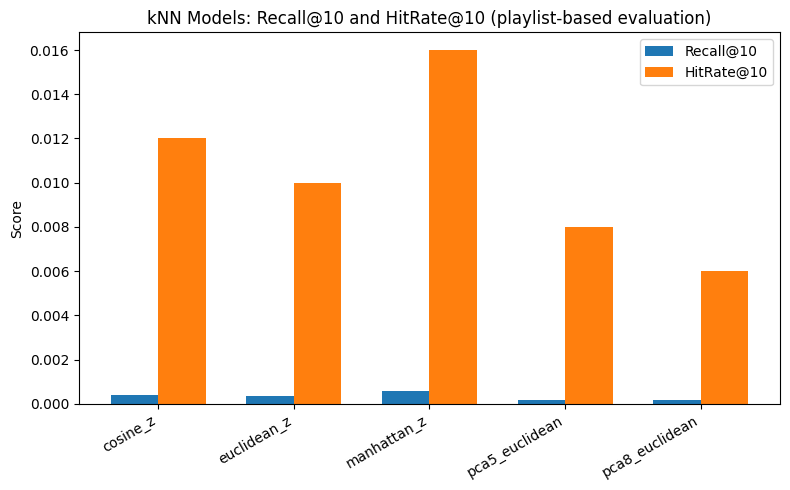

In [18]:
plt.figure(figsize=(8, 5))

x = np.arange(len(metrics_df))
width = 0.35

plt.bar(x - width/2, metrics_df["recall_at_10"], width, label="Recall@10")
plt.bar(x + width/2, metrics_df["hit_rate_at_10"], width, label="HitRate@10")

plt.xticks(x, metrics_df["model"], rotation=30, ha="right")
plt.ylabel("Score")
plt.title("kNN Models: Recall@10 and HitRate@10 (playlist-based evaluation)")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# ---- Extra ranking metrics helpers: AP@k and NDCG@k ----

import math

def average_precision_at_k(ranked_ids, relevant_ids, k):
    """
    Compute Average Precision@k for a single ranked list.

    ranked_ids : list of recommended track_ids (ordered)
    relevant_ids : set of ground-truth relevant track_ids
    k : cutoff

    Returns AP@k in [0,1].
    """
    if not relevant_ids:
        return 0.0

    hits = 0
    sum_precisions = 0.0
    for i, tid in enumerate(ranked_ids[:k], start=1):
        if tid in relevant_ids:
            hits += 1
            precision_i = hits / i
            sum_precisions += precision_i

    # Normalise by min(num_relevant, k)
    denom = min(len(relevant_ids), k)
    if denom == 0:
        return 0.0
    return sum_precisions / denom


def ndcg_at_k(ranked_ids, relevant_ids, k):
    """
    Compute NDCG@k for binary relevance.

    ranked_ids : list of recommended track_ids (ordered)
    relevant_ids : set of ground-truth relevant track_ids
    k : cutoff

    Returns NDCG@k in [0,1].
    """
    # DCG
    dcg = 0.0
    for i, tid in enumerate(ranked_ids[:k], start=1):
        rel = 1.0 if tid in relevant_ids else 0.0
        if rel > 0:
            dcg += rel / math.log2(i + 1)

    # IDCG (ideal DCG)
    max_rels = min(len(relevant_ids), k)
    if max_rels == 0:
        return 0.0

    idcg = 0.0
    for i in range(1, max_rels + 1):
        idcg += 1.0 / math.log2(i + 1)

    if idcg == 0:
        return 0.0

    return dcg / idcg


In [20]:
# ---- Multi-k evaluation for kNN models: Recall, HitRate, Precision, MAP, NDCG ----

def evaluate_knn_model_multi_k(
    model_name: str,
    Ks = (5, 10, 20, 50),
    num_playlists: int = 500,
    seed: int = 0,
):
    """
    Offline evaluation of a kNN model over multiple cutoffs K.

    For each sampled playlist:
      - choose 1 seed track
      - relevant tracks = all other tracks in that playlist
      - compute metrics at each K in Ks:
          * Recall@K
          * HitRate@K
          * Precision@K
          * MAP@K
          * NDCG@K

    Returns:
        metrics_df: DataFrame indexed by metric name, columns = K values.
    """
    rng = random.Random(seed)
    Ks = sorted(list(Ks))
    max_k = Ks[-1]

    sampled_pids = rng.sample(
        playlist_ids_eval,
        min(num_playlists, len(playlist_ids_eval))
    )

    # Accumulators: metric_name -> K -> list of values
    stats = {
        "Recall": {k: [] for k in Ks},
        "HitRate": {k: [] for k in Ks},
        "Precision": {k: [] for k in Ks},
        "MAP": {k: [] for k in Ks},
        "NDCG": {k: [] for k in Ks},
    }

    n_eval = 0

    for pid in sampled_pids:
        tracks = playlist_to_tracks[pid]
        if len(tracks) < 2:
            continue

        seed_track = rng.choice(tracks)
        relevant = set(tracks) - {seed_track}
        if not relevant:
            continue

        try:
            rec_df = knn_recommend(model_name, seed_track, top_k=max_k)
        except ValueError:
            # seed track not in the KNN universe
            continue

        ranked_ids = list(rec_df["track_id"])
        if not ranked_ids:
            continue

        n_eval += 1

        for k in Ks:
            topk = ranked_ids[:k]
            topk_set = set(topk)

            n_hits = len(relevant & topk_set)
            recall_k = n_hits / len(relevant)
            hit_k = 1.0 if n_hits > 0 else 0.0
            precision_k = n_hits / len(topk) if topk else 0.0
            ap_k = average_precision_at_k(ranked_ids, relevant, k)
            ndcg_k = ndcg_at_k(ranked_ids, relevant, k)

            stats["Recall"][k].append(recall_k)
            stats["HitRate"][k].append(hit_k)
            stats["Precision"][k].append(precision_k)
            stats["MAP"][k].append(ap_k)
            stats["NDCG"][k].append(ndcg_k)

    # Aggregate
    data = {}
    for metric_name, per_k in stats.items():
        data[metric_name] = {
            k: float(np.mean(vals)) if len(vals) > 0 else 0.0
            for k, vals in per_k.items()
        }

    metrics_df = pd.DataFrame(data).T  # rows = metrics, cols = Ks
    metrics_df.columns = [f"@{k}" for k in Ks]
    metrics_df.index.name = f"{model_name} metrics"
    return metrics_df, n_eval


# Example: evaluate all KNN variants for K ∈ {5, 10, 20, 50}
K_LIST = [5, 10, 20, 50]

multi_k_results = {}
for mname in model_names:
    print(f"\nEvaluating multi-K metrics for model: {mname}")
    metrics_df, n_eval = evaluate_knn_model_multi_k(
        mname,
        Ks=K_LIST,
        num_playlists=500,
        seed=42,
    )
    print(f"  Playlists evaluated: {n_eval}")
    display(metrics_df.style.format("{:.4f}"))
    multi_k_results[mname] = metrics_df



Evaluating multi-K metrics for model: cosine_z
  Playlists evaluated: 500


,@5,@10,@20,@50
cosine_z metrics,,,,
Recall,0.0003,0.0004,0.0006,0.0012
HitRate,0.0060,0.0120,0.0160,0.0380
Precision,0.0012,0.0012,0.0008,0.0010
MAP,0.0004,0.0003,0.0002,0.0002
NDCG,0.0010,0.0011,0.0009,0.0013



Evaluating multi-K metrics for model: euclidean_z
  Playlists evaluated: 500


,@5,@10,@20,@50
euclidean_z metrics,,,,
Recall,0.0003,0.0004,0.0007,0.0009
HitRate,0.0060,0.0100,0.0200,0.0360
Precision,0.0012,0.0010,0.0010,0.0008
MAP,0.0004,0.0003,0.0002,0.0002
NDCG,0.0010,0.0009,0.0010,0.0011



Evaluating multi-K metrics for model: manhattan_z
  Playlists evaluated: 500


,@5,@10,@20,@50
manhattan_z metrics,,,,
Recall,0.0003,0.0006,0.0008,0.0013
HitRate,0.0080,0.0160,0.0220,0.0420
Precision,0.0016,0.0016,0.0011,0.0011
MAP,0.0007,0.0005,0.0003,0.0003
NDCG,0.0016,0.0016,0.0013,0.0016



Evaluating multi-K metrics for model: pca5_euclidean
  Playlists evaluated: 500


,@5,@10,@20,@50
pca5_euclidean metrics,,,,
Recall,0.0000,0.0002,0.0002,0.0003
HitRate,0.0020,0.0080,0.0100,0.0200
Precision,0.0004,0.0008,0.0005,0.0004
MAP,0.0004,0.0003,0.0001,0.0001
NDCG,0.0007,0.0009,0.0006,0.0005



Evaluating multi-K metrics for model: pca8_euclidean
  Playlists evaluated: 500


,@5,@10,@20,@50
pca8_euclidean metrics,,,,
Recall,0.0002,0.0002,0.0003,0.0009
HitRate,0.0060,0.0060,0.0140,0.0360
Precision,0.0012,0.0006,0.0007,0.0008
MAP,0.0006,0.0003,0.0002,0.0002
NDCG,0.0013,0.0008,0.0009,0.0011


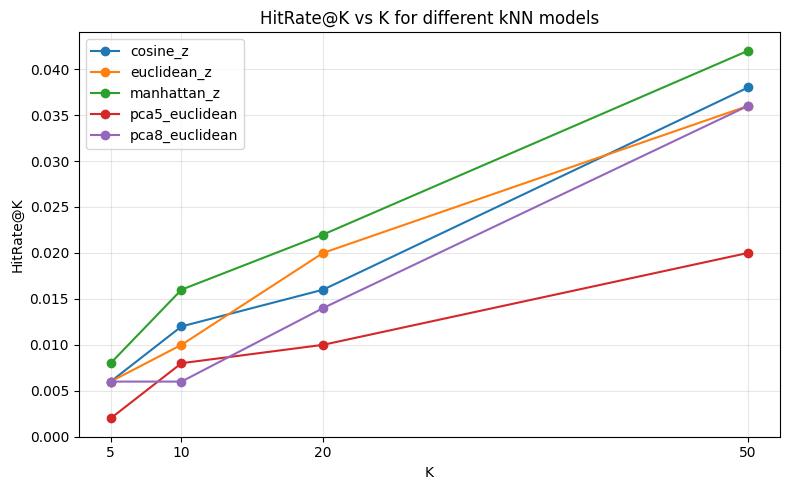

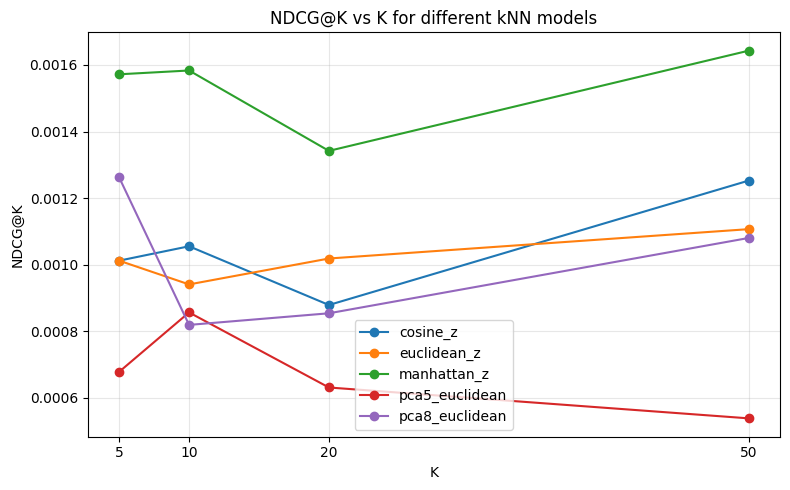

In [21]:
# ---- Plot HitRate@k and NDCG@k vs K for each model ----

plt.figure(figsize=(8, 5))
for mname in model_names:
    df = multi_k_results[mname]
    ks = [int(col.strip("@")) for col in df.columns]
    plt.plot(
        ks,
        df.loc["HitRate"].values,
        marker="o",
        label=mname,
    )
plt.xlabel("K")
plt.ylabel("HitRate@K")
plt.title("HitRate@K vs K for different kNN models")
plt.xticks(K_LIST)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
for mname in model_names:
    df = multi_k_results[mname]
    ks = [int(col.strip("@")) for col in df.columns]
    plt.plot(
        ks,
        df.loc["NDCG"].values,
        marker="o",
        label=mname,
    )
plt.xlabel("K")
plt.ylabel("NDCG@K")
plt.title("NDCG@K vs K for different kNN models")
plt.xticks(K_LIST)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
# ---- Optional: compact comparison table at a single K (e.g. K=10) ----

K_STAR = 10
col_name = f"@{K_STAR}"

rows = []
for mname in model_names:
    df = multi_k_results[mname]
    rows.append({
        "model": mname,
        "Recall": df.loc["Recall", col_name],
        "HitRate": df.loc["HitRate", col_name],
        "Precision": df.loc["Precision", col_name],
        "MAP": df.loc["MAP", col_name],
        "NDCG": df.loc["NDCG", col_name],
    })

summary_kstar = pd.DataFrame(rows)
display(summary_kstar.style.format("{:.4f}"))


ValueError: Unknown format code 'f' for object of type 'str'

In [23]:
# ---- Optional: compact comparison table at a single K (e.g. K=10) ----

K_STAR = 10
col_name = f"@{K_STAR}"

rows = []
for mname in model_names:
    df = multi_k_results[mname]
    rows.append({
        "model": mname,
        "Recall": df.loc["Recall", col_name],
        "HitRate": df.loc["HitRate", col_name],
        "Precision": df.loc["Precision", col_name],
        "MAP": df.loc["MAP", col_name],
        "NDCG": df.loc["NDCG", col_name],
    })

summary_kstar = pd.DataFrame(rows)

# Convert all numeric columns to float to ensure proper formatting
numeric_cols = ["Recall", "HitRate", "Precision", "MAP", "NDCG"]
summary_kstar[numeric_cols] = summary_kstar[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Display with formatting
display(summary_kstar.style.format({
    "Recall": "{:.4f}",
    "HitRate": "{:.4f}",
    "Precision": "{:.4f}",
    "MAP": "{:.4f}",
    "NDCG": "{:.4f}"
}))

,model,Recall,HitRate,Precision,MAP,NDCG
0,cosine_z,0.0004,0.0120,0.0012,0.0003,0.0011
1,euclidean_z,0.0004,0.0100,0.0010,0.0003,0.0009
2,manhattan_z,0.0006,0.0160,0.0016,0.0005,0.0016
3,pca5_euclidean,0.0002,0.0080,0.0008,0.0003,0.0009
4,pca8_euclidean,0.0002,0.0060,0.0006,0.0003,0.0008


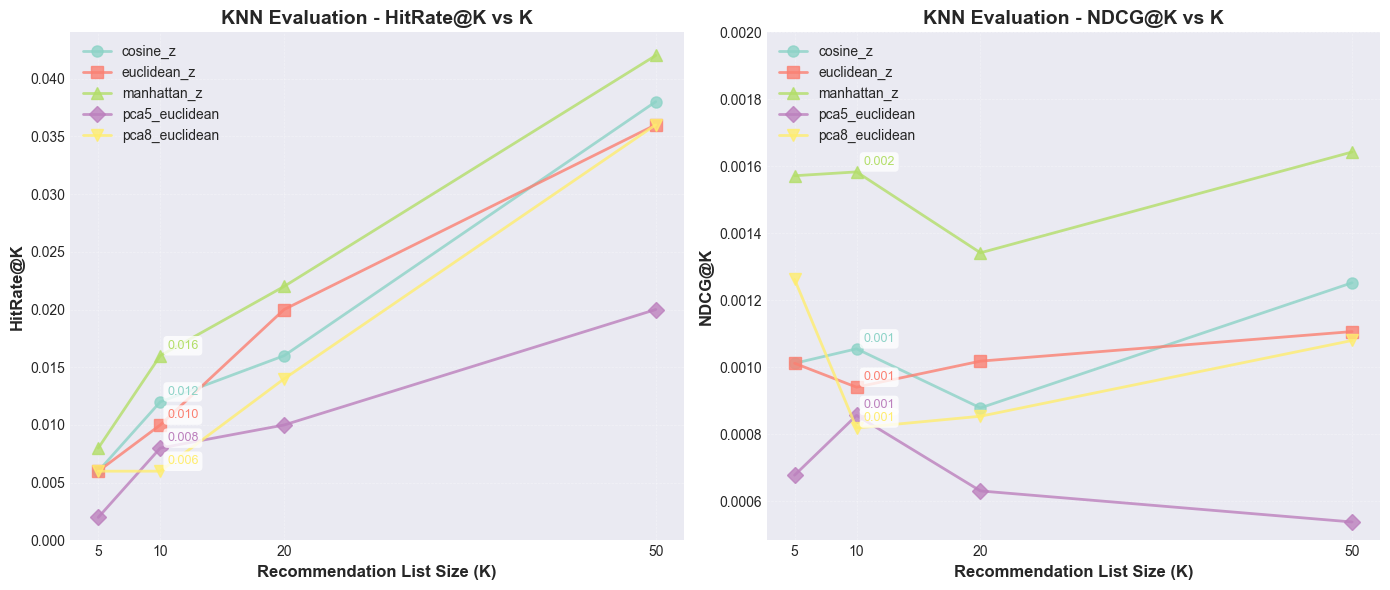

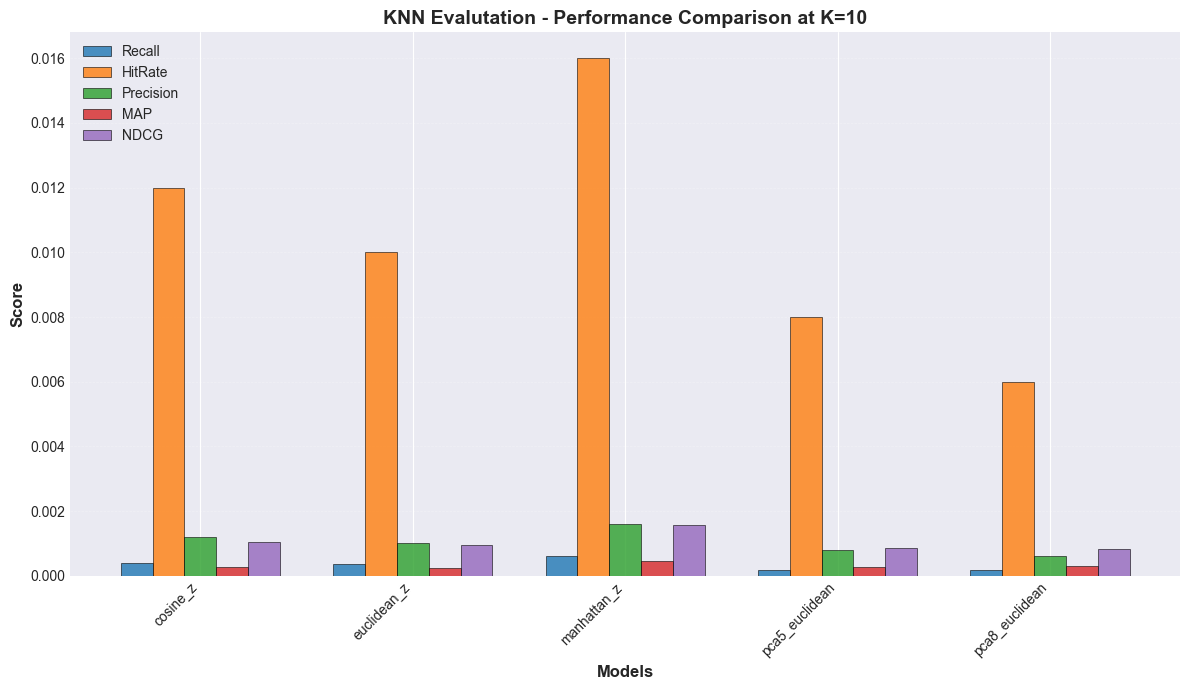

In [31]:
# ---- Improved Plot: HitRate@k and NDCG@k vs K for each model ----

# Custom styling for better visual appeal
plt.style.use('seaborn-v0_8-darkgrid')  # Professional style with grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color palette for models
colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', 'd']  # Different markers for each model

# Plot 1: HitRate@K
for idx, mname in enumerate(model_names):
    df = multi_k_results[mname]
    ks = [int(col.strip("@")) for col in df.columns]
    axes[0].plot(
        ks,
        df.loc["HitRate"].values,
        marker=markers[idx % len(markers)],
        markersize=8,
        linewidth=2,
        color=colors[idx],
        label=mname,
        alpha=0.8
    )

axes[0].set_xlabel("Recommendation List Size (K)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("HitRate@K", fontsize=12, fontweight='bold')
axes[0].set_title("KNN Evaluation - HitRate@K vs K", fontsize=14, fontweight='bold')
axes[0].set_xticks(K_LIST)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].legend(fontsize=10, loc='best', framealpha=0.9, shadow=True)
axes[0].grid(True, alpha=0.4, linestyle='--', linewidth=0.5)

# Add value annotations for K=10
for idx, mname in enumerate(model_names):
    df = multi_k_results[mname]
    k10_value = df.loc["HitRate", "@10"]
    axes[0].annotate(f'{k10_value:.3f}', 
                    xy=(10, k10_value),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=9,
                    color=colors[idx],
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))

# Plot 2: NDCG@K
for idx, mname in enumerate(model_names):
    df = multi_k_results[mname]
    ks = [int(col.strip("@")) for col in df.columns]
    axes[1].plot(
        ks,
        df.loc["NDCG"].values,
        marker=markers[idx % len(markers)],
        markersize=8,
        linewidth=2,
        color=colors[idx],
        label=mname,
        alpha=0.8
    )

axes[1].set_xlabel("Recommendation List Size (K)", fontsize=12, fontweight='bold')
axes[1].set_ylabel("NDCG@K", fontsize=12, fontweight='bold')
axes[1].set_title("KNN Evaluation - NDCG@K vs K", fontsize=14, fontweight='bold')
axes[1].set_xticks(K_LIST)
axes[1].set_ylim(top=0.002)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].legend(fontsize=10, loc='upper left', framealpha=0.9, shadow=True)
axes[1].grid(True, alpha=0.4, linestyle='--', linewidth=0.5)

# Add value annotations for K=10
for idx, mname in enumerate(model_names):
    df = multi_k_results[mname]
    k10_value = df.loc["NDCG", "@10"]
    axes[1].annotate(f'{k10_value:.3f}', 
                    xy=(10, k10_value),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=9,
                    color=colors[idx],
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

# ---- Additional: Combined plot with all metrics at K=10 ----

fig, ax = plt.subplots(figsize=(12, 7))

# Prepare data
x = np.arange(len(model_names))
width = 0.15
metrics = ['Recall', 'HitRate', 'Precision', 'MAP', 'NDCG']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, metric in enumerate(metrics):
    values = []
    for mname in model_names:
        df = multi_k_results[mname]
        values.append(df.loc[metric, "@10"])
    
    ax.bar(x + i*width - 2*width, values, width, label=metric, color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('KNN Evalutation - Performance Comparison at K=10', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10, loc='upper left', framealpha=0.9, shadow=True)
ax.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.show()